In [133]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel Bühler for this suggestion

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

import keras
print(keras.__version__)


LR = 1e-3
MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '4conv-basic') # just so we remember which saved model is which, sizes must match

2.0.9


### Preparing the Data
This function resizes the images to 64x64 and samples 2000 images (8%) of the data to run efficiently as a Kaggle Kernel. I also separated cats and dogs for exploratory analysis.

In [129]:
TRAIN_DIR = 'C:/Users/swillin/courses/kaggle/cat_dog/train/'
TEST_DIR = 'C:/Users/swillin/courses/kaggle/cat_dog/test/'

ROWS = 64
COLS = 64
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

print(len(train_cats))
print(len(train_dogs))


12500
12500


In [86]:
IMG_SIZE = 50

def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]
    
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [87]:
train_data = create_train_data()
#test_data = create_test_data()

100%|██████████| 25000/25000 [01:10<00:00, 355.47it/s]


In [136]:
import tensorflow as tf
tf.reset_default_graph()  # Important

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [137]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')
    
train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [138]:
print(X.shape)
print(len(Y))
print(test_x.shape)
print(len(test_y))

(24500, 50, 50, 1)
24500
(500, 50, 50, 1)
500


In [139]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=50, show_metric=True, run_id=MODEL_NAME)

Training Step: 1914  | total loss: 0.40415 | time: 130.813s
| Adam | epoch: 005 | loss: 0.40415 - acc: 0.8111 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.42558 | time: 132.172s
| Adam | epoch: 005 | loss: 0.42558 - acc: 0.7972 | val_loss: 0.46177 - val_acc: 0.7660 -- iter: 24500/24500
--


In [140]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\swillin\courses\kaggle\cat_dog\dogsvscats-0.001-4conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


tensorboard --logdir=C:\Users\swillin\courses\kaggle\cat_dog\log\dogsvscats-0.001-2conv-basic.model

In [ ]:
import matplotlib.pyplot as plt

# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
#test_data = np.load('test_data.npy')

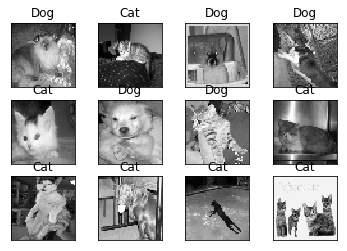

In [146]:
fig=plt.figure()
for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_label='Dog'
    else: 
        str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()


In [147]:
with open('submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|██████████| 12500/12500 [00:43<00:00, 285.83it/s]


In [97]:
# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images = train_dogs[:2000] + train_cats[:2000]
print(len(train_images))
random.shuffle(train_images)
test_images =  test_images[:25]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    img = img[:,:,::-1]
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

4000
Processed 0 of 4000
Processed 250 of 4000
Processed 500 of 4000
Processed 750 of 4000
Processed 1000 of 4000
Processed 1250 of 4000
Processed 1500 of 4000
Processed 1750 of 4000
Processed 2000 of 4000
Processed 2250 of 4000
Processed 2500 of 4000
Processed 2750 of 4000
Processed 3000 of 4000
Processed 3250 of 4000
Processed 3500 of 4000
Processed 3750 of 4000
Processed 0 of 25
Train shape: (4000, 64, 64, 3)
Test shape: (25, 64, 64, 3)


### Generating the Labels
We're dealing with a binary classification problem here - (1) dog (0) cat. The lables can be created by looping over the file names in the train directory. It's nice to see the training data is perfectly balanced.

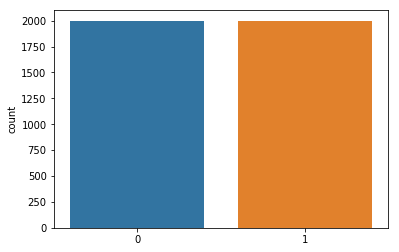

In [71]:
labels = []
for i in train_images:
    if '/dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)
sns.title = 'Cats and Dogs'

### Checking out Cats and Dogs
A quick side-by-side comparison of the animals.

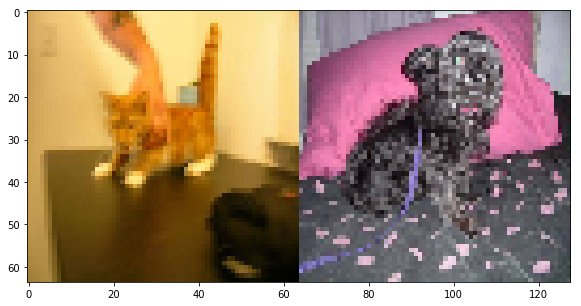

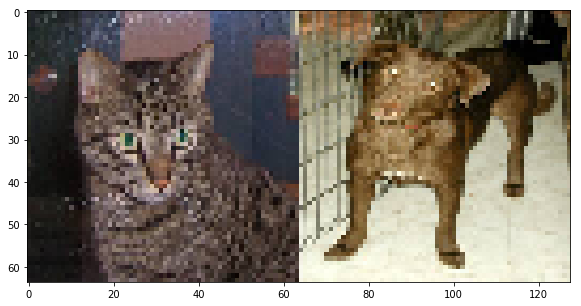

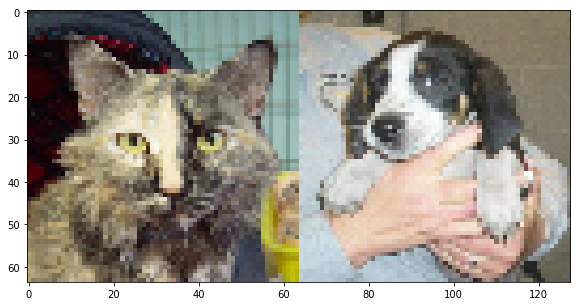

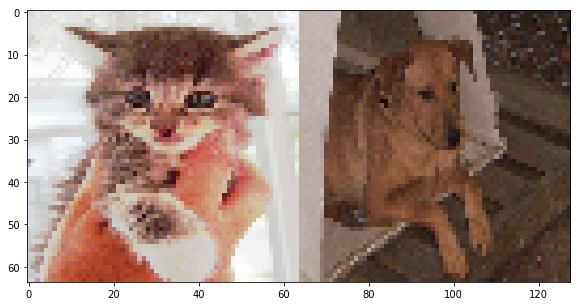

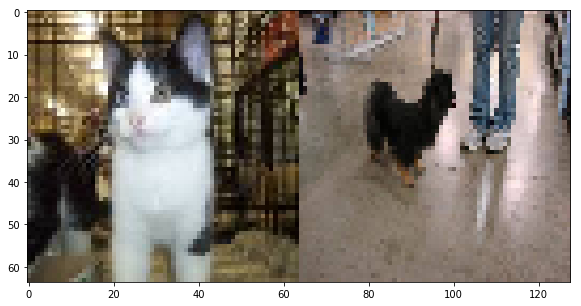

In [72]:
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

### CatdogNet-16
A scaled down version of the VGG-16, with a few notable changes.

    *Number of convolution filters cut in half, fully connected (dense) layers scaled down.
    *Optimizer changed to RMSprop.
    *Output layer activation set to sigmoid for binary crossentropy.
    *Some layers commented out for efficiency.
The full network takes about 80s per epoch on a GTX1070 (or 2hr+ on CPU) on the full dataset. (This script only trains on 8% of the 25K images. )

In [75]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def catdog():
    
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(ROWS, COLS, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(2, 2))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = catdog()

### Train and Predict
I'm using Keras's early stopping callback to end training when the validation loss stops improving, otherwise the model will overfit. I will also be tracking the loss history on each epoch to visualize the overfitting trend.

Note: A slice of 1000 images was used to fit the model for CPU efficency. The model's perfrmance improves significantly when used on the entire dataset.

In [76]:
nb_epoch = 20
batch_size = 64

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, epochs=nb_epoch, validation_split=0.25, verbose=0, shuffle=True, 
              callbacks=[history, early_stopping])
    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()

Epoch 00004: early stopping


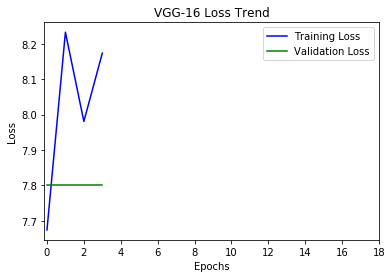

In [77]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

In [78]:
print(predictions)

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


0
0.581436
I am 58.14% sure this is a Dog


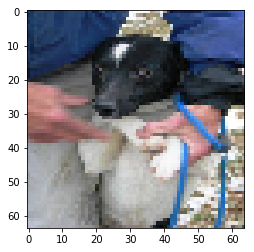

1
0.553789
I am 55.38% sure this is a Dog


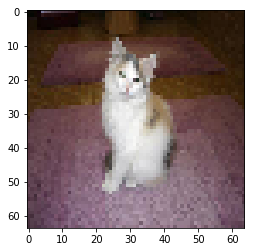

2
0.580387
I am 58.04% sure this is a Dog


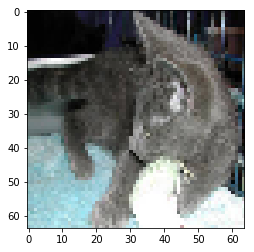

3
0.630601
I am 63.06% sure this is a Dog


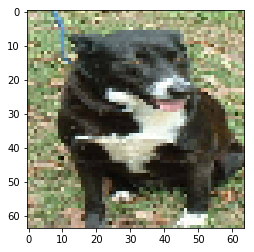

4
0.651904
I am 65.19% sure this is a Dog


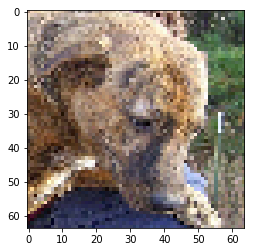

5
0.638973
I am 63.90% sure this is a Dog


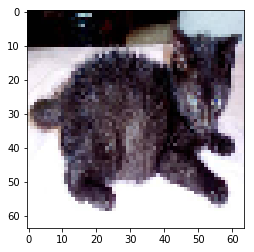

6
0.543736
I am 54.37% sure this is a Dog


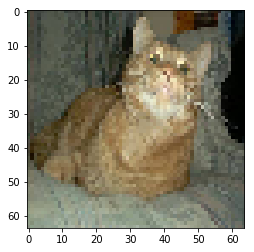

7
0.665717
I am 66.57% sure this is a Dog


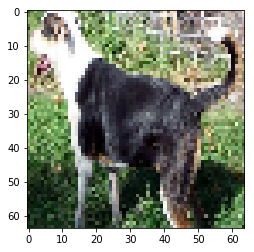

8
0.598387
I am 59.84% sure this is a Dog


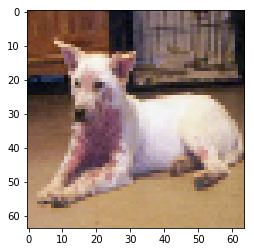

9
0.57037
I am 57.04% sure this is a Dog


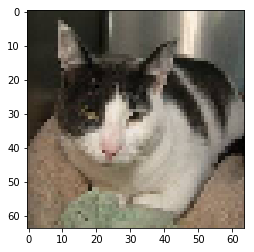

In [69]:
for i in range(0,10):
    print(i)
    print(predictions[i][0] )
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i])
    plt.show()